# machine learning model to predict how much someone will spend based on demographics and offer type.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## import libs and read data

In [1]:
import pandas as pd
import numpy as np
import math
import json

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore and prepare data.

In [2]:
print(portfolio.shape)

# transform days into hours
portfolio["duration"] = portfolio["duration"] * 24
portfolio.rename(columns={"id": "offer_id"}, inplace=True)

portfolio

(10, 6)


,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Create a complete  DataFrame for offers and transactions.

In [5]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Here we can see that a funil is create on each step of creation

Lets analyse and prepare each event type.

In [6]:
offer_received = transcript.loc[transcript['event'] == "offer received"]
offer_received

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576


In [7]:
offer_id = offer_received.value.str['offer id']

offer_id = pd.DataFrame(offer_id)
offer_id.rename(columns={'value': "offer_id"}, inplace=True)

offer_received = pd.concat([offer_received, offer_id], axis=1)

offer_received.drop(['value', 'event'], axis=1, inplace=True)

offer_received = offer_received.merge(portfolio, on="offer_id")
                                      
offer_received["finish_time"] = offer_received.time + offer_received.duration

In [8]:
offer_received

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168
...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648
76273,1c35792f115f4d06b138a63edf84ee4d,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648
76274,5ca2620962114246ab218fc648eb3934,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648
76275,f924927e7f844ecebf87eef93f4d2688,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648


In [9]:
offer_viewed = transcript.loc[transcript['event'] == "offer viewed"]
offer_viewed

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
...,...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714


In [10]:
offer_id = offer_viewed.value.str['offer id']

offer_id = pd.DataFrame(offer_id)
offer_id.rename(columns={'value': "offer_id"}, inplace=True)

offer_viewed = pd.concat([offer_viewed, offer_id], axis=1)

offer_viewed.drop(['value', 'event'], axis=1, inplace=True)

offer_viewed = offer_viewed.merge(portfolio, on="offer_id")

In [11]:
offer_viewed

,person,time,offer_id,reward,channels,difficulty,duration,offer_type
0,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,120,bogo
1,262ad0fb526a4d53b572007da60cce24,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,120,bogo
2,182e68952b474700b171e21b85c258ac,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,120,bogo
3,6d28f18e91324d358d69d1e4b01f1ace,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,120,bogo
4,569866874d614a6a9c30d9f1e3a23b8d,0,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,120,bogo
...,...,...,...,...,...,...,...,...
57720,a4f3350b08934d41a80e526317842b40,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,240,discount
57721,62e9e17c69784b6a82f6630ee3e3e82b,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,240,discount
57722,f8ed60edd102473ab78cd33c6a044d3f,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,240,discount
57723,345f9431137a49b3963221a55567c4a8,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,240,discount


In [12]:
offer_completed = transcript.loc[transcript['event'] == "offer completed"]
offer_completed

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0
...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


In [13]:
offer_id = offer_completed.value.str['offer_id']

offer_id = pd.DataFrame(offer_id)
offer_id.rename(columns={'value': "offer_id"}, inplace=True)

offer_completed = pd.concat([offer_completed, offer_id], axis=1)

offer_completed.drop(['value',"event"], axis=1, inplace=True)

offer_completed = offer_completed.merge(portfolio, on="offer_id")

offer_completed

,person,time,offer_id,reward,channels,difficulty,duration,offer_type
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,168,discount
1,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,168,discount
2,24115a61df25473e84a8a03f3c98de1a,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,168,discount
3,2481f1fcfbcb4b288e5a03af02d95373,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,168,discount
4,a45b69f1c8554ae7af83e74426ca437a,0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,168,discount
...,...,...,...,...,...,...,...,...
33574,5cb65af515664bb0b39cdaa089244dc7,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,240,discount
33575,0dc85918181e4c3eb0e412d37fa8a552,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,240,discount
33576,f74033a8c6834303bd1b3ef0c98d11d8,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,240,discount
33577,f3e801caeafe4899b3b989b586e74ac7,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,240,discount


In [14]:
transaction = transcript.loc[transcript['event'] == "transaction"]
transaction

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [15]:
amount = transaction.value.str['amount']

amount = pd.DataFrame(amount)
amount.rename(columns={'value': "amount"}, inplace=True)

transaction = pd.concat([transaction, amount], axis=1)

transaction.drop(['value', 'event'], axis=1, inplace=True)

transaction

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
306531,a00058cf10334a308c68e7631c529907,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53


In [16]:
offer_viewed.rename(columns={"time": "view_time"}, inplace=True)
offer_completed.rename(columns={"time": "comp_time"}, inplace=True)

## Create a complete offers dataset

In [17]:
offer_received.shape

(76277, 9)

For each offer received create, find if it was viewed

In [18]:
viewed_group = offer_viewed.groupby("person")

def was_viewed(row):
    try:
        user_view = viewed_group.get_group(row["person"])
    except:
        return False

    user_view = user_view.loc[(user_view["offer_id"] == row["offer_id"]) & 
                              (user_view["view_time"] >= row["time"])   &
                              (user_view["view_time"] <= row["finish_time"])]
    

    return bool(user_view.shape[0])

offers = offer_received.copy()

offers["viewed"] = offers.apply(lambda row: was_viewed(row), axis=1)

offers

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,False
...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648,False
76273,1c35792f115f4d06b138a63edf84ee4d,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648,True
76274,5ca2620962114246ab218fc648eb3934,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648,False
76275,f924927e7f844ecebf87eef93f4d2688,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648,True


For each offer received create, find if it was viewed

In [19]:
completed_group = offer_completed.groupby("person")

def was_completed(row):
    try:
        user_comp = completed_group.get_group(row["person"])
    except:
        return False

    user_comp = user_comp.loc[(user_comp["offer_id"] == row["offer_id"]) & 
                              (user_comp["comp_time"] >= row["time"])   &
                              (user_comp["comp_time"] <= row["finish_time"])]
    

    return bool(user_comp.shape[0])

offers["completed"] = offers.apply(lambda row: was_completed(row), axis=1)

offers

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,False,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,168,bogo,168,False,False
...,...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648,False,False
76273,1c35792f115f4d06b138a63edf84ee4d,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648,True,False
76274,5ca2620962114246ab218fc648eb3934,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648,False,False
76275,f924927e7f844ecebf87eef93f4d2688,576,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,72,informational,648,True,False


Transform portfolio id in sequential for better visualization.

In [20]:
portfolio['offer_id'] = portfolio['offer_id'].rank(method='dense', ascending=False).astype(int)

In [21]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,168,bogo,3
1,10,"[web, email, mobile, social]",10,120,bogo,6
2,0,"[web, email, mobile]",0,96,informational,7
3,5,"[web, email, mobile]",5,168,bogo,4
4,5,"[web, email]",20,240,discount,10
5,3,"[web, email, mobile, social]",7,168,discount,9
6,2,"[web, email, mobile, social]",10,240,discount,1
7,0,"[email, mobile, social]",0,72,informational,5
8,5,"[web, email, mobile, social]",5,120,bogo,2
9,2,"[web, email, mobile]",10,168,discount,8


In [22]:
offers['offer_id'] = offers['offer_id'].rank(method='dense', ascending=False).astype(int)
offers

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,4,5,"[web, email, mobile]",5,168,bogo,168,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,4,5,"[web, email, mobile]",5,168,bogo,168,False,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,4,5,"[web, email, mobile]",5,168,bogo,168,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,4,5,"[web, email, mobile]",5,168,bogo,168,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,4,5,"[web, email, mobile]",5,168,bogo,168,False,False
...,...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5,0,"[email, mobile, social]",0,72,informational,648,False,False
76273,1c35792f115f4d06b138a63edf84ee4d,576,5,0,"[email, mobile, social]",0,72,informational,648,True,False
76274,5ca2620962114246ab218fc648eb3934,576,5,0,"[email, mobile, social]",0,72,informational,648,False,False
76275,f924927e7f844ecebf87eef93f4d2688,576,5,0,"[email, mobile, social]",0,72,informational,648,True,False


In [23]:
offers["difficulty"] = offers["reward"] / offers["difficulty"]
offers["difficulty"].fillna(0)
offers

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,False,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,False,False
...,...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5,0,"[email, mobile, social]",NaN,72,informational,648,False,False
76273,1c35792f115f4d06b138a63edf84ee4d,576,5,0,"[email, mobile, social]",NaN,72,informational,648,True,False
76274,5ca2620962114246ab218fc648eb3934,576,5,0,"[email, mobile, social]",NaN,72,informational,648,False,False
76275,f924927e7f844ecebf87eef93f4d2688,576,5,0,"[email, mobile, social]",NaN,72,informational,648,True,False


## Plot infos to understand data

In [24]:
print(f"Offers received {offer_received.shape[0]}")
print(f"Offers viewed {offer_viewed.shape[0]}")
print(f"Offers Completed {offer_completed.shape[0]}")

Offers received 76277
Offers viewed 57725
Offers Completed 33579


In [25]:
print(f"Offers received {offers.shape[0]}")
print(f"Offers viewed {offers.viewed.sum()}")
print(f"Offers Completed {offers.completed.sum()}")

Offers received 76277
Offers viewed 56895
Offers Completed 33631


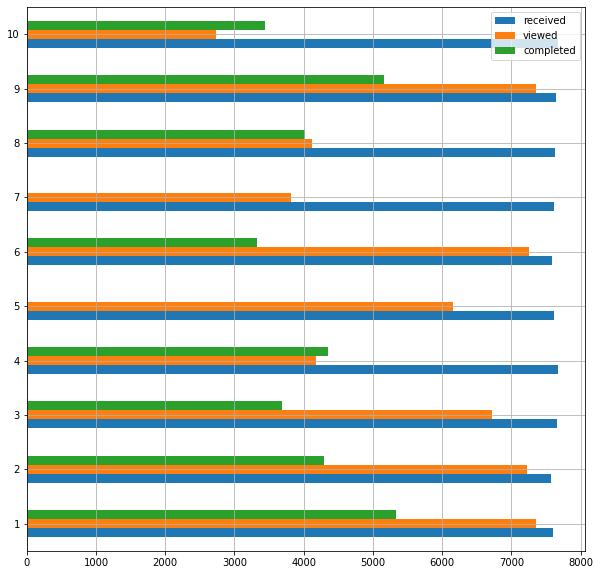

In [26]:
offers_group = offers.groupby("offer_id")


plt.rcParams["figure.figsize"] = (10,10)
df = pd.DataFrame({'received': offers_group.person.count().values,
                   'viewed': offers_group.viewed.sum().values,
                   'completed': offers_group.completed.sum().values}, 
                  index=offers_group.groups.keys())

ax = df.plot.barh(rot=0)

plt.grid()
plt.show()

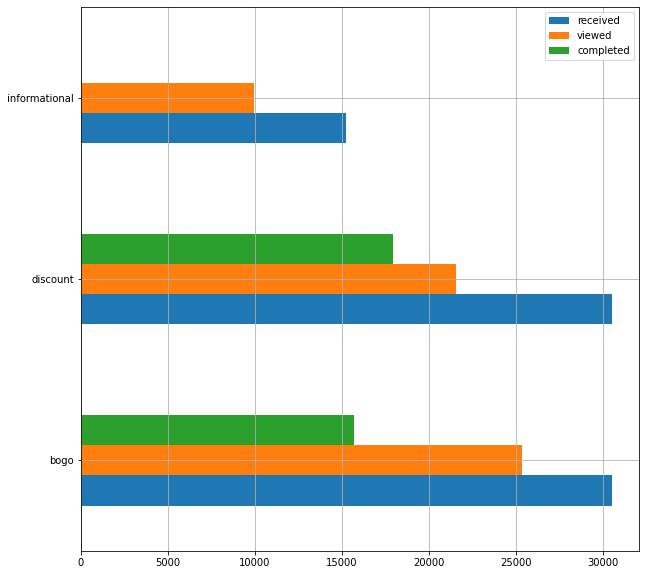

In [27]:
offers_group = offers.groupby("offer_type")

df = pd.DataFrame({'received': offers_group.person.count().values,
                   'viewed': offers_group.viewed.sum().values,
                   'completed': offers_group.completed.sum().values}, 
                  index=offers_group.groups.keys())

ax = df.plot.barh(rot=0)

plt.grid()
plt.show()

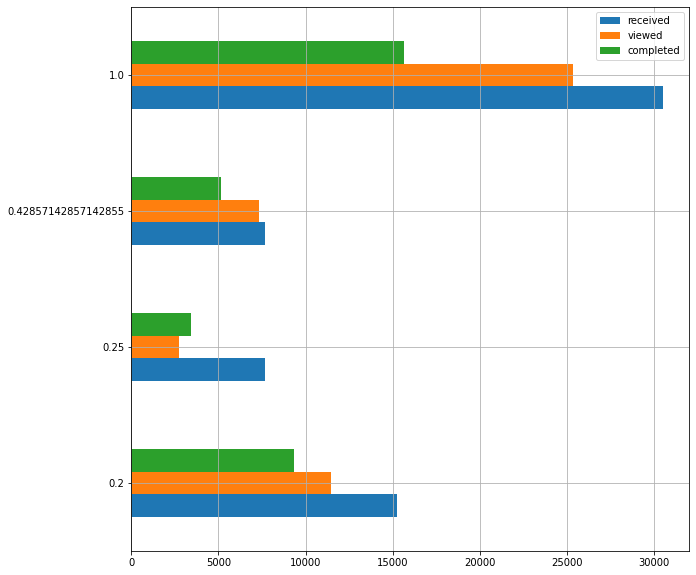

In [28]:
offers_group = offers.groupby("difficulty")

df = pd.DataFrame({'received': offers_group.person.count().values,
                   'viewed': offers_group.viewed.sum().values,
                   'completed': offers_group.completed.sum().values}, 
                  index=offers_group.groups.keys())

ax = df.plot.barh(rot=0)

plt.grid()
plt.show()

## Explore profile and trasaction.

In [29]:
print(f"Total income NaN value {profile.income.isna().sum() / profile.shape[0]}")


# Fill NaN income values with 0

profile.income = profile.income.fillna(0)
profile.head()

Total income NaN value 0.12794117647058822


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,0.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,0.0


People with zero income are, probaly, the ones with no register.

<AxesSubplot:>

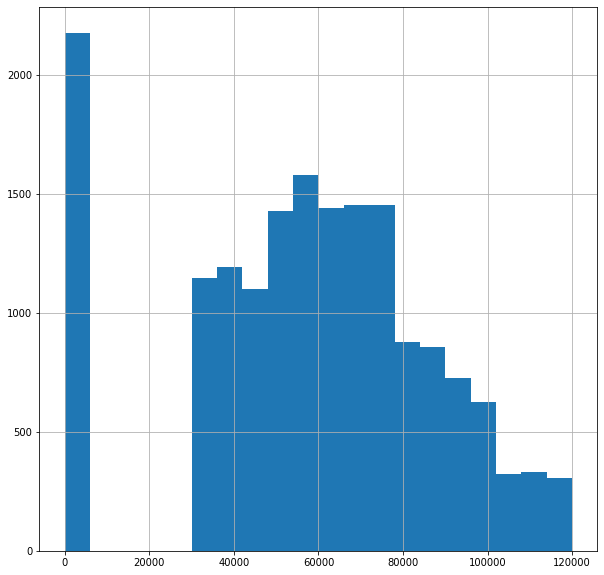

In [30]:
profile.income.hist(bins=20)

Sum the amount each customer spent

In [31]:
amount_sum = pd.pivot_table(transaction, values='amount', index=['person'], 
                         aggfunc=np.sum)
amount_count = pd.pivot_table(transaction, values='amount', index=['person'], 
                         aggfunc=np.count_nonzero)
amount_count.columns = ['count']
df_count_sum = pd.concat([amount_sum, amount_count], axis=1)
df_count_sum = df_count_sum.reset_index()
df_count_sum.columns = ['id', 'amount', 'count']

df_count_sum

,id,amount,count
0,0009655768c64bdeb2e877511632db8f,127.60,8
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5
3,0020c2b971eb4e9188eac86d93036a77,196.86,8
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12
...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,580.98,11
16574,fff7576017104bcc8677a8d63322b5e1,29.94,6
16575,fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5
16576,fffad4f4828548d1b5583907f2e9906b,88.83,12


In [32]:
complete_profile  = pd.merge(profile, df_count_sum, on="id")
complete_profile

,gender,age,id,became_member_on,income,amount,count
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0,20.40,9
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,0.0,14.30,6
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,0.0,4.65,3
...,...,...,...,...,...,...,...
16573,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,20.03,7
16574,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7
16575,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,39.74,8
16576,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14


In [33]:
offer_received_count = pd.pivot_table(offer_received, values="offer_id", index=['person'], aggfunc=np.count_nonzero)

offer_received_count = offer_received_count.reset_index()
offer_received_count.columns = ['id','offers_received']

offer_received_count

,id,offers_received
0,0009655768c64bdeb2e877511632db8f,5
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,5
3,0020c2b971eb4e9188eac86d93036a77,5
4,0020ccbbb6d84e358d3414a3ff76cffd,4
...,...,...
16989,fff3ba4757bd42088c044ca26d73817a,6
16990,fff7576017104bcc8677a8d63322b5e1,5
16991,fff8957ea8b240a6b5e634b6ee8eafcf,3
16992,fffad4f4828548d1b5583907f2e9906b,4


In [34]:
complete_profile  = pd.merge(complete_profile, offer_received_count, on="id")
complete_profile

,gender,age,id,became_member_on,income,amount,count,offers_received
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0,20.40,9,5
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,0.0,14.30,6,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,0.0,4.65,3,5
...,...,...,...,...,...,...,...,...
16567,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,20.03,7,3
16568,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3
16569,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,39.74,8,3
16570,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3


In [35]:
offer_mean_reward= pd.pivot_table(offer_completed, values='reward', index=['person'],
                                    aggfunc=np.mean)

offer_count = pd.pivot_table(offer_completed, values='offer_id', index=['person'],
                                    aggfunc=np.count_nonzero)

com_offer_completed = pd.concat([offer_mean_reward, offer_count], axis=1)
com_offer_completed = com_offer_completed.reset_index()
com_offer_completed.columns = ['id','avg_reward','offers_done']

com_offer_completed


,id,avg_reward,offers_done
0,0009655768c64bdeb2e877511632db8f,3.000000,3
1,0011e0d4e6b944f998e987f904e8c1e5,4.333333,3
2,0020c2b971eb4e9188eac86d93036a77,4.666667,3
3,0020ccbbb6d84e358d3414a3ff76cffd,4.333333,3
4,003d66b6608740288d6cc97a6903f4f0,3.000000,3
...,...,...,...
12769,fff29fb549084123bd046dbc5ceb4faa,7.833333,6
12770,fff3ba4757bd42088c044ca26d73817a,3.000000,3
12771,fff7576017104bcc8677a8d63322b5e1,3.000000,3
12772,fffad4f4828548d1b5583907f2e9906b,5.000000,3


In [36]:
complete_profile

,gender,age,id,became_member_on,income,amount,count,offers_received
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0,20.40,9,5
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,0.0,14.30,6,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,0.0,4.65,3,5
...,...,...,...,...,...,...,...,...
16567,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,20.03,7,3
16568,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3
16569,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,39.74,8,3
16570,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3


In [37]:
complete_profile = pd.merge(complete_profile, com_offer_completed, on="id")
complete_profile['purchase_rate'] = complete_profile['offers_done']/complete_profile['offers_received']

complete_profile


,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0,20.40,9,5,2.500000,2,0.400000
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2,5.000000,1,0.500000
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4,6.666667,3,0.750000
3,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3,4,3.500000,2,0.500000
4,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3,6,3.800000,5,0.833333
...,...,...,...,...,...,...,...,...,...,...,...
12769,F,70,79edb810789c447e8d212a324b44cc16,20160310,39000.0,143.75,15,5,3.750000,4,0.800000
12770,M,60,cb23b66c56f64b109d673d5e56574529,20180505,113000.0,115.59,5,3,2.000000,1,0.333333
12771,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3,5.000000,1,0.333333
12772,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3,8.333333,3,1.000000


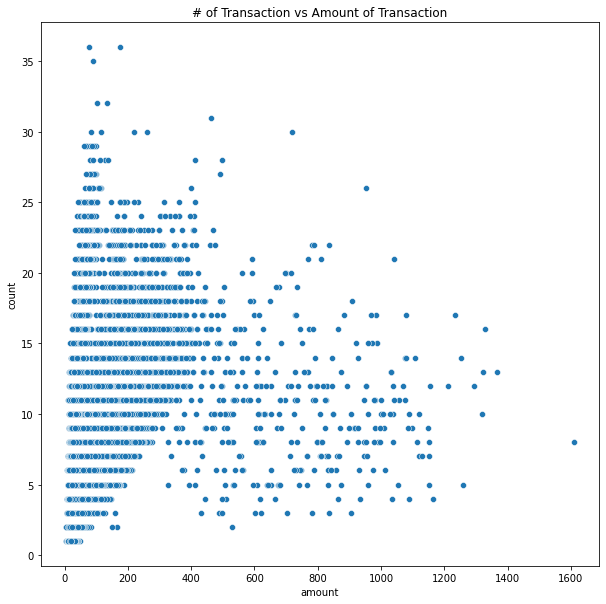

In [38]:
fig, ax = plt.subplots()

sn.scatterplot(x=complete_profile['amount'], 
               y=complete_profile['count']).set_title('# of Transaction vs Amount of Transaction');

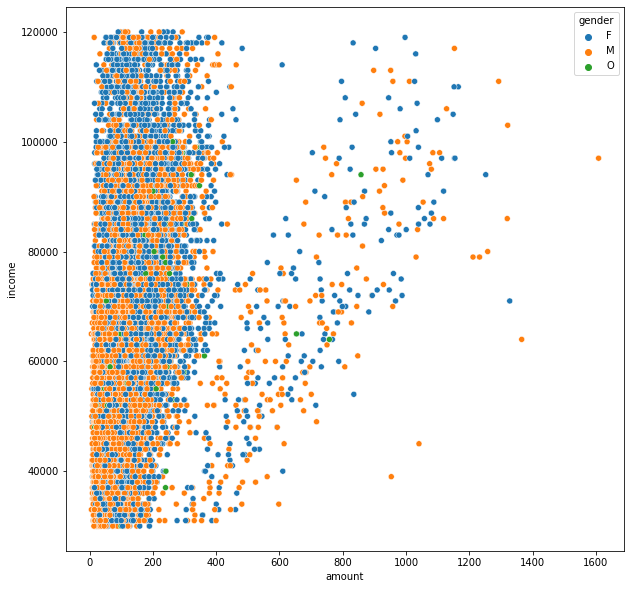

In [39]:
fig, ax = plt.subplots()

sn.scatterplot(x=complete_profile['amount'], 
               y=complete_profile['income'],
               hue=complete_profile['gender']);

In [40]:
complete_profile = complete_profile[complete_profile["age"] < 100].reset_index()

del complete_profile['index']
complete_profile["age"].describe()

count    11969.000000
mean        55.172613
std         16.966390
min         18.000000
25%         44.000000
50%         56.000000
75%         67.000000
max         99.000000
Name: age, dtype: float64

# Create categoricals values for our models

In [41]:
def age_label_func(row):
    if row['age'] <= 30: return "young-adult"
    elif row['age'] <= 60: return "adult"
    else: return "elderly"
    
complete_profile['age_label'] = complete_profile.apply(lambda row: age_label_func(row), axis=1)

complete_profile

,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2,5.000000,1,0.500000,adult
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4,6.666667,3,0.750000,elderly
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3,4,3.500000,2,0.500000,elderly
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3,6,3.800000,5,0.833333,elderly
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4,3,2.000000,1,0.333333,adult
...,...,...,...,...,...,...,...,...,...,...,...,...
11964,F,70,79edb810789c447e8d212a324b44cc16,20160310,39000.0,143.75,15,5,3.750000,4,0.800000,elderly
11965,M,60,cb23b66c56f64b109d673d5e56574529,20180505,113000.0,115.59,5,3,2.000000,1,0.333333,adult
11966,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3,5.000000,1,0.333333,elderly
11967,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3,8.333333,3,1.000000,elderly


In [42]:
def income_label_func(row):
    if row['income'] <= 60000: return "avarage"
    elif row['income'] <= 90000: return "above-average"
    else: return "high"
    
complete_profile['income_label'] = complete_profile.apply(lambda row: income_label_func(row), axis=1)

complete_profile

,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label,income_label
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3,2,5.000000,1,0.500000,adult,high
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7,4,6.666667,3,0.750000,elderly,high
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3,4,3.500000,2,0.500000,elderly,above-average
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3,6,3.800000,5,0.833333,elderly,avarage
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4,3,2.000000,1,0.333333,adult,avarage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,F,70,79edb810789c447e8d212a324b44cc16,20160310,39000.0,143.75,15,5,3.750000,4,0.800000,elderly,avarage
11965,M,60,cb23b66c56f64b109d673d5e56574529,20180505,113000.0,115.59,5,3,2.000000,1,0.333333,adult,high
11966,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7,3,5.000000,1,0.333333,elderly,above-average
11967,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14,3,8.333333,3,1.000000,elderly,avarage


In [43]:
complete_profile["became_member_on"] = complete_profile["became_member_on"].astype(str).str[:4]
complete_profile

,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label,income_label
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017,112000.0,77.01,3,2,5.000000,1,0.500000,adult,high
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0,159.27,7,4,6.666667,3,0.750000,elderly,high
2,M,68,e2127556f4f64592b11af22de27a7932,2018,70000.0,57.73,3,4,3.500000,2,0.500000,elderly,above-average
3,M,65,389bc3fa690240e798340f5a15918d5c,2018,53000.0,36.43,3,6,3.800000,5,0.833333,elderly,avarage
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0,15.62,4,3,2.000000,1,0.333333,adult,avarage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,F,70,79edb810789c447e8d212a324b44cc16,2016,39000.0,143.75,15,5,3.750000,4,0.800000,elderly,avarage
11965,M,60,cb23b66c56f64b109d673d5e56574529,2018,113000.0,115.59,5,3,2.000000,1,0.333333,adult,high
11966,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018,72000.0,25.97,7,3,5.000000,1,0.333333,elderly,above-average
11967,F,83,9dc1421481194dcd9400aec7c9ae6366,2016,50000.0,189.67,14,3,8.333333,3,1.000000,elderly,avarage


# Merge profile and offers dataset

In [44]:
complete_profile

,gender,age,id,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label,income_label
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017,112000.0,77.01,3,2,5.000000,1,0.500000,adult,high
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0,159.27,7,4,6.666667,3,0.750000,elderly,high
2,M,68,e2127556f4f64592b11af22de27a7932,2018,70000.0,57.73,3,4,3.500000,2,0.500000,elderly,above-average
3,M,65,389bc3fa690240e798340f5a15918d5c,2018,53000.0,36.43,3,6,3.800000,5,0.833333,elderly,avarage
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0,15.62,4,3,2.000000,1,0.333333,adult,avarage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,F,70,79edb810789c447e8d212a324b44cc16,2016,39000.0,143.75,15,5,3.750000,4,0.800000,elderly,avarage
11965,M,60,cb23b66c56f64b109d673d5e56574529,2018,113000.0,115.59,5,3,2.000000,1,0.333333,adult,high
11966,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018,72000.0,25.97,7,3,5.000000,1,0.333333,elderly,above-average
11967,F,83,9dc1421481194dcd9400aec7c9ae6366,2016,50000.0,189.67,14,3,8.333333,3,1.000000,elderly,avarage


In [45]:
complete_df = offers.copy()

complete_df.rename(columns={"person": "id"}, inplace=True)

complete_df = complete_df.merge(complete_profile, on="id", how="left")
complete_df

,id,time,offer_id,reward,channels,difficulty,duration,offer_type,finish_time,viewed,...,became_member_on,income,amount,count,offers_received,avg_reward,offers_done,purchase_rate,age_label,income_label
0,78afa995795e4d85b5d9ceeca43f5fef,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,True,...,2017,100000.0,159.27,7.0,4.0,6.666667,3.0,0.750000,elderly,high
1,ebe7ef46ea6f4963a7dd49f501b26779,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,False,...,2015,41000.0,52.08,13.0,6.0,2.000000,2.0,0.333333,adult,avarage
2,f082d80f0aac47a99173ba8ef8fc1909,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,True,...,2016,33000.0,40.94,14.0,6.0,5.000000,1.0,0.166667,adult,avarage
3,c0d210398dee4a0895b24444a5fcd1d2,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,True,...,2018,33000.0,61.25,8.0,5.0,6.000000,3.0,0.600000,adult,avarage
4,57dd18ec5ddc46828afb81ec5977bef2,0,4,5,"[web, email, mobile]",1.0,168,bogo,168,False,...,2017,80000.0,249.40,9.0,6.0,5.666667,3.0,0.500000,adult,above-average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,daad151d84664dd6a4809ab8f05af690,576,5,0,"[email, mobile, social]",NaN,72,informational,648,False,...,2016,86000.0,305.57,15.0,6.0,5.400000,5.0,0.833333,adult,above-average
76273,1c35792f115f4d06b138a63edf84ee4d,576,5,0,"[email, mobile, social]",NaN,72,informational,648,True,...,2017,71000.0,248.26,14.0,6.0,7.500000,2.0,0.333333,elderly,above-average
76274,5ca2620962114246ab218fc648eb3934,576,5,0,"[email, mobile, social]",NaN,72,informational,648,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76275,f924927e7f844ecebf87eef93f4d2688,576,5,0,"[email, mobile, social]",NaN,72,informational,648,True,...,2016,93000.0,266.11,11.0,6.0,5.000000,4.0,0.666667,adult,high


## What is the most commom offer for each age group?

The users with 118 years are the users that doesn't want to response the age. So we will drop it.

<AxesSubplot:>

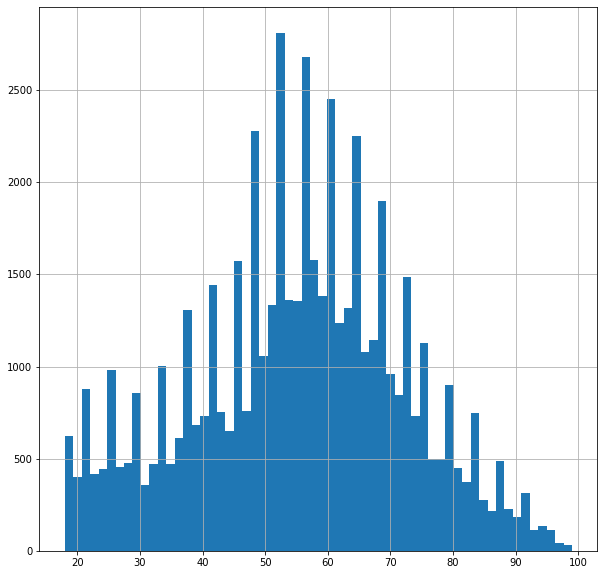

In [46]:
complete_df['age'].hist(bins=60)

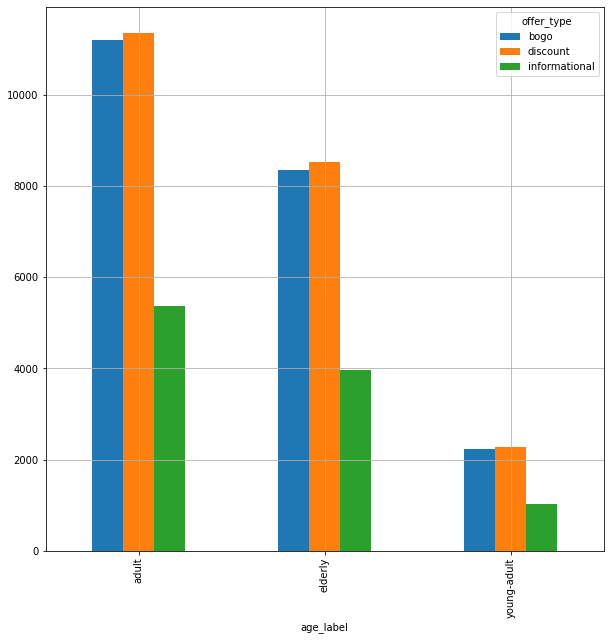

In [47]:
complete_df.groupby("offer_type").age_label.value_counts().unstack(0).plot.bar()

plt.grid()
plt.show()

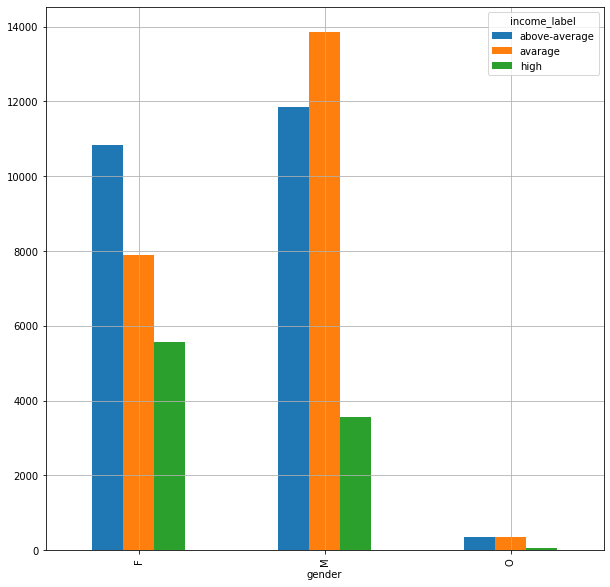

In [48]:
complete_df.groupby("income_label").gender.value_counts().unstack(0).plot.bar()

plt.grid()
plt.show()

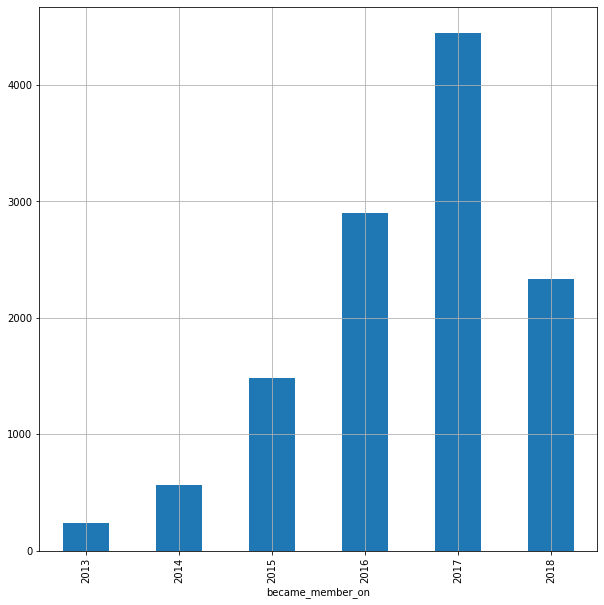

In [49]:
complete_profile.groupby("became_member_on").id.count().plot.bar()

plt.grid()
plt.show()

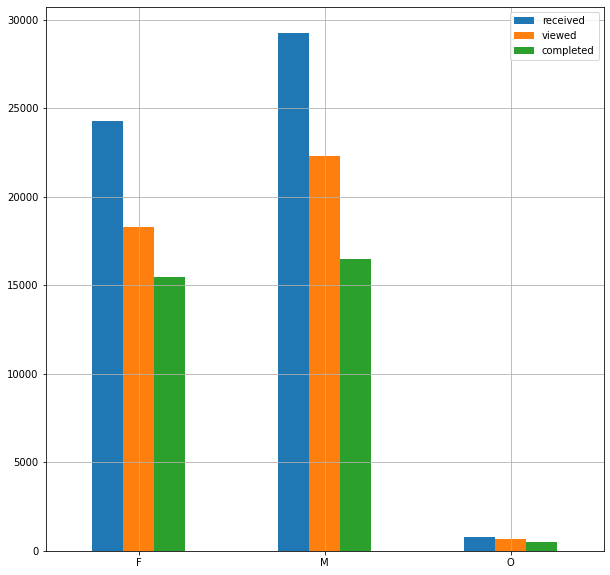

In [50]:
offers_group = complete_df.groupby("gender")


df = pd.DataFrame({'received': offers_group.id.count().values,
                   'viewed': offers_group.viewed.sum().values,
                   'completed': offers_group.completed.sum().values}, 
                  index=offers_group.groups.keys())

ax = df.plot.bar(rot=0)

plt.grid()
plt.show()

 # Lets create a spend label to our predictions

In [51]:
complete_profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'amount', 'count',
       'offers_received', 'avg_reward', 'offers_done', 'purchase_rate',
       'age_label', 'income_label'],
      dtype='object')

In [52]:
complete_profile['amount'].describe()

count    11969.000000
mean       139.611514
std        133.518325
min          5.280000
25%         57.340000
50%        112.160000
75%        179.640000
max       1608.690000
Name: amount, dtype: float64

In [53]:
def get_spent_propenssion_label(row):  
    spent_propension = row['amount'] / row['income']
    
    
    if spent_propension <= 0.000799: return "very low"
    elif spent_propension <= 0.001570: return "low"
    elif spent_propension <= 0.002607: return "medium"
    elif spent_propension <= 0.005: return "high"
    else: return "very high"

complete_profile['spent_label'] = complete_profile.apply(lambda row: get_spent_propenssion_label(row), axis=1)


complete_profile['spent_label']

0        very low
1          medium
2             low
3        very low
4        very low
           ...   
11964        high
11965         low
11966    very low
11967        high
11968      medium
Name: spent_label, Length: 11969, dtype: object

/home/vl/Courses/Udacity/dataScience/project1/CRISP-DM/jupyterenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


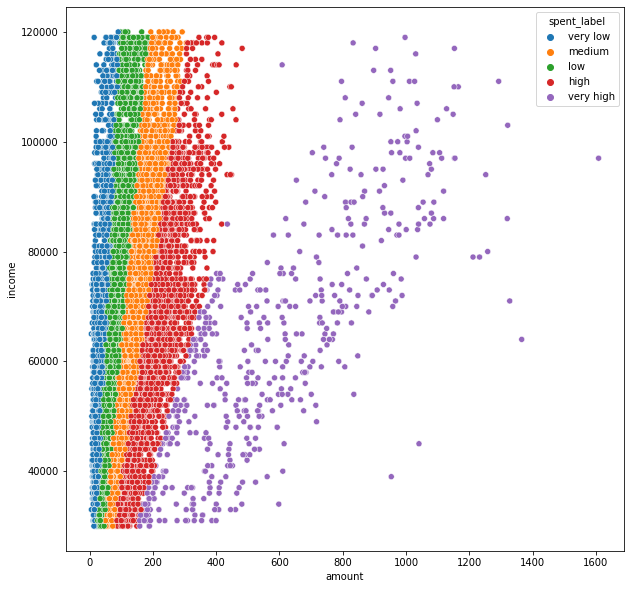

In [54]:
fig, ax = plt.subplots()
sn.scatterplot(complete_profile['amount'], complete_profile['income'], hue=complete_profile['spent_label']);

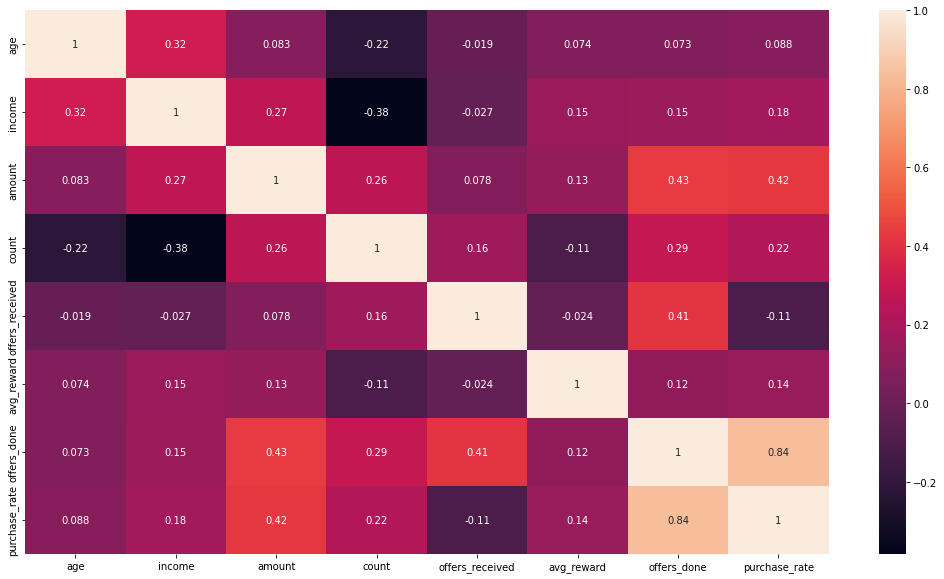

In [55]:
fig, ax = plt.subplots(figsize=(18,10))
sn.heatmap(complete_profile.corr(), annot = True, ax=ax)
plt.show()

## Random Forrest Classifier to preedict wspent label

In [56]:
dummie_df = complete_profile.copy()

In [57]:
dummie_df.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'amount', 'count',
       'offers_received', 'avg_reward', 'offers_done', 'purchase_rate',
       'age_label', 'income_label', 'spent_label'],
      dtype='object')

In [58]:
dummie_df = pd.concat([dummie_df, pd.get_dummies(dummie_df["gender"])], axis=1)
del dummie_df['gender']

dummie_df = pd.concat([dummie_df, pd.get_dummies(dummie_df["age_label"])], axis=1)
del dummie_df['age_label']

dummie_df = pd.concat([dummie_df, pd.get_dummies(dummie_df["income_label"])], axis=1)
del dummie_df['income_label']

dummie_df.columns

Index(['age', 'id', 'became_member_on', 'income', 'amount', 'count',
       'offers_received', 'avg_reward', 'offers_done', 'purchase_rate',
       'spent_label', 'F', 'M', 'O', 'adult', 'elderly', 'young-adult',
       'above-average', 'avarage', 'high'],
      dtype='object')

In [59]:
X = dummie_df[['F', 'M', 'O', 'adult', 'elderly', 'young-adult', 'above-average', 'avarage',
       'high', "became_member_on", 'offers_received', 'offers_done', 'income', 'amount']]

X

,F,M,O,adult,elderly,young-adult,above-average,avarage,high,became_member_on,offers_received,offers_done,income,amount
0,1,0,0,1,0,0,0,0,1,2017,2,1,112000.0,77.01
1,1,0,0,0,1,0,0,0,1,2017,4,3,100000.0,159.27
2,0,1,0,0,1,0,1,0,0,2018,4,2,70000.0,57.73
3,0,1,0,0,1,0,0,1,0,2018,6,5,53000.0,36.43
4,0,1,0,1,0,0,0,1,0,2017,3,1,51000.0,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,1,0,0,0,1,0,0,1,0,2016,5,4,39000.0,143.75
11965,0,1,0,1,0,0,0,0,1,2018,3,1,113000.0,115.59
11966,0,1,0,0,1,0,1,0,0,2018,3,1,72000.0,25.97
11967,1,0,0,0,1,0,0,1,0,2016,3,3,50000.0,189.67


In [60]:
y = complete_profile[['spent_label']]
y

,spent_label
0,very low
1,medium
2,low
3,very low
4,very low
...,...
11964,high
11965,low
11966,very low
11967,high


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [62]:
X_test.columns

Index(['F', 'M', 'O', 'adult', 'elderly', 'young-adult', 'above-average',
       'avarage', 'high', 'became_member_on', 'offers_received', 'offers_done',
       'income', 'amount'],
      dtype='object')

In [63]:
# lests reserve income, cus its direct influency on presicitons.

X_test_income = X_test['income']
X_test_amount = X_test['amount']


X_test.drop(['income', 'amount'], inplace=True, axis=1)
X_train.drop(['income', 'amount'], inplace=True, axis=1)

In [64]:
rf_pipeline = Pipeline([
        #('scaler', StandardScaler()),
        ('clf', RandomForestClassifier())
])

parameters = {
        'clf__n_estimators' : range(5, 200, 5)
    }

cv = GridSearchCV(rf_pipeline, param_grid=parameters, verbose=3)

In [65]:
cv.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 39 candidates, totalling 195 fits
[CV 1/5] END ...............clf__n_estimators=5;, score=0.440 total time=   0.0s
[CV 2/5] END ...............clf__n_estimators=5;, score=0.423 total time=   0.0s
[CV 3/5] END ...............clf__n_estimators=5;, score=0.406 total time=   0.0s
[CV 4/5] END ...............clf__n_estimators=5;, score=0.443 total time=   0.0s
[CV 5/5] END ...............clf__n_estimators=5;, score=0.425 total time=   0.0s
[CV 1/5] END ..............clf__n_estimators=10;, score=0.438 total time=   0.0s
[CV 2/5] END ..............clf__n_estimators=10;, score=0.434 total time=   0.0s
[CV 3/5] END ..............clf__n_estimators=10;, score=0.416 total time=   0.0s
[CV 4/5] END ..............clf__n_estimators=10;, score=0.439 total time=   0.0s
[CV 5/5] END ..............clf__n_estimators=10;, score=0.418 total time=   0.0s
[CV 1/5] END ..............clf__n_estimators=15;, score=0.445 total time=   0.1s
[CV 2/5] END ..............clf__n_estimators=15

[CV 2/5] END .............clf__n_estimators=105;, score=0.431 total time=   0.3s
[CV 3/5] END .............clf__n_estimators=105;, score=0.408 total time=   0.3s
[CV 4/5] END .............clf__n_estimators=105;, score=0.447 total time=   0.3s
[CV 5/5] END .............clf__n_estimators=105;, score=0.414 total time=   0.3s
[CV 1/5] END .............clf__n_estimators=110;, score=0.443 total time=   0.4s
[CV 2/5] END .............clf__n_estimators=110;, score=0.437 total time=   0.4s
[CV 3/5] END .............clf__n_estimators=110;, score=0.409 total time=   0.4s
[CV 4/5] END .............clf__n_estimators=110;, score=0.450 total time=   0.4s
[CV 5/5] END .............clf__n_estimators=110;, score=0.417 total time=   0.4s
[CV 1/5] END .............clf__n_estimators=115;, score=0.445 total time=   0.4s
[CV 2/5] END .............clf__n_estimators=115;, score=0.436 total time=   0.4s
[CV 3/5] END .............clf__n_estimators=115;, score=0.410 total time=   0.4s
[CV 4/5] END .............cl

GridSearchCV(estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
             param_grid={'clf__n_estimators': range(5, 200, 5)}, verbose=3)

In [66]:
cv.best_params_

{'clf__n_estimators': 165}

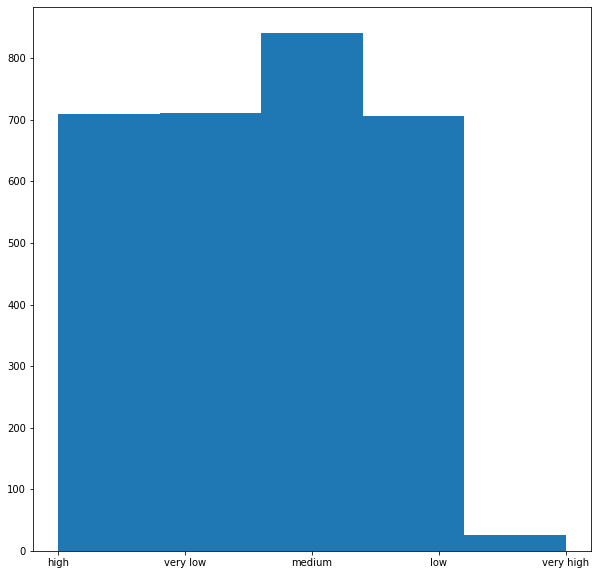

In [67]:
y_pred = cv.predict(X_test)

plt.hist(y_pred, bins=5);

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.43      0.47      0.45       648
         low       0.43      0.37      0.40       823
      medium       0.34      0.37      0.36       779
   very high       0.16      0.03      0.05       128
    very low       0.58      0.67      0.62       615

    accuracy                           0.44      2993
   macro avg       0.39      0.38      0.38      2993
weighted avg       0.43      0.44      0.43      2993



# Lets use SVC to compare results

In [69]:
svc_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC())
])



parameters = {
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

svc_cv = GridSearchCV(svc_pipeline, param_grid=parameters, verbose=3)


In [70]:
svc_cv.fit(X_train, y_train.values.ravel())


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................clf__kernel=linear;, score=0.468 total time=   1.7s
[CV 2/5] END ................clf__kernel=linear;, score=0.478 total time=   1.7s
[CV 3/5] END ................clf__kernel=linear;, score=0.447 total time=   1.6s
[CV 4/5] END ................clf__kernel=linear;, score=0.470 total time=   1.6s
[CV 5/5] END ................clf__kernel=linear;, score=0.455 total time=   1.7s
[CV 1/5] END ..................clf__kernel=poly;, score=0.465 total time=   1.8s
[CV 2/5] END ..................clf__kernel=poly;, score=0.482 total time=   1.9s
[CV 3/5] END ..................clf__kernel=poly;, score=0.467 total time=   1.9s
[CV 4/5] END ..................clf__kernel=poly;, score=0.466 total time=   1.9s
[CV 5/5] END ..................clf__kernel=poly;, score=0.455 total time=   2.1s
[CV 1/5] END ...................clf__kernel=rbf;, score=0.478 total time=   2.1s
[CV 2/5] END ...................clf__kernel=rbf;,

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

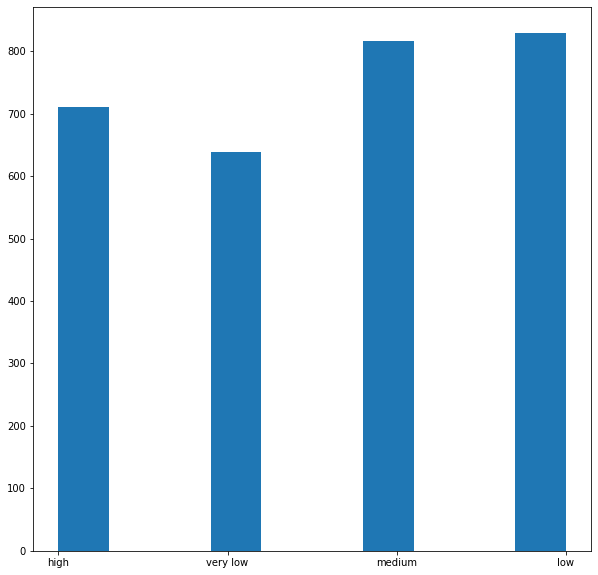

In [71]:
y_pred_svc = svc_cv.predict(X_test)
plt.hist(y_pred_svc);

In [72]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

        high       0.47      0.51      0.49       648
         low       0.43      0.44      0.44       823
      medium       0.39      0.40      0.39       779
   very high       0.00      0.00      0.00       128
    very low       0.61      0.64      0.63       615

    accuracy                           0.47      2993
   macro avg       0.38      0.40      0.39      2993
weighted avg       0.45      0.47      0.46      2993



/home/vl/Courses/Udacity/dataScience/project1/CRISP-DM/jupyterenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vl/Courses/Udacity/dataScience/project1/CRISP-DM/jupyterenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vl/Courses/Udacity/dataScience/project1/CRISP-DM/jupyterenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

# Remove class imbalance

In [73]:
X_train

,F,M,O,adult,elderly,young-adult,above-average,avarage,high,became_member_on,offers_received,offers_done
10469,1,0,0,1,0,0,0,1,0,2017,3,3
2551,0,1,0,1,0,0,1,0,0,2018,4,2
8369,0,1,0,1,0,0,1,0,0,2016,4,4
3818,0,1,0,1,0,0,0,1,0,2015,4,4
4302,1,0,0,1,0,0,0,1,0,2013,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
6783,0,1,0,0,1,0,0,0,1,2018,5,2
2097,1,0,0,1,0,0,1,0,0,2015,3,2
4640,1,0,0,1,0,0,0,1,0,2017,4,3
10988,0,1,0,1,0,0,1,0,0,2015,3,2


In [74]:
over_sampler = SMOTE(k_neighbors=2)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res.spent_label)}")
print(f"Testing target statistics: {Counter(y_test.spent_label)}")

Training target statistics: Counter({'high': 2408, 'medium': 2408, 'very high': 2408, 'very low': 2408, 'low': 2408})
Testing target statistics: Counter({'low': 823, 'medium': 779, 'high': 648, 'very low': 615, 'very high': 128})


In [75]:
svc_cv.fit(X_res, y_res.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................clf__kernel=linear;, score=0.405 total time=   2.9s
[CV 2/5] END ................clf__kernel=linear;, score=0.420 total time=   3.2s
[CV 3/5] END ................clf__kernel=linear;, score=0.422 total time=   3.0s
[CV 4/5] END ................clf__kernel=linear;, score=0.417 total time=   3.0s
[CV 5/5] END ................clf__kernel=linear;, score=0.409 total time=   3.0s
[CV 1/5] END ..................clf__kernel=poly;, score=0.444 total time=   2.9s
[CV 2/5] END ..................clf__kernel=poly;, score=0.448 total time=   2.9s
[CV 3/5] END ..................clf__kernel=poly;, score=0.462 total time=   2.9s
[CV 4/5] END ..................clf__kernel=poly;, score=0.457 total time=   2.9s
[CV 5/5] END ..................clf__kernel=poly;, score=0.454 total time=   2.9s
[CV 1/5] END ...................clf__kernel=rbf;, score=0.446 total time=   3.4s
[CV 2/5] END ...................clf__kernel=rbf;,

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

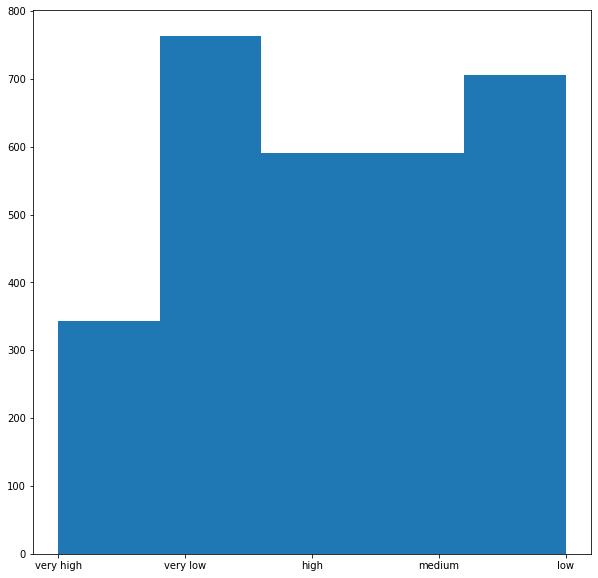

In [76]:

y_pred_svc_balanced = svc_cv.predict(X_test)

plt.hist(y_pred_svc_balanced, bins=5);

In [77]:
print(classification_report(y_test, y_pred_svc_balanced))

              precision    recall  f1-score   support

        high       0.42      0.38      0.40       648
         low       0.44      0.38      0.41       823
      medium       0.39      0.30      0.34       779
   very high       0.13      0.34      0.19       128
    very low       0.56      0.70      0.62       615

    accuracy                           0.42      2993
   macro avg       0.39      0.42      0.39      2993
weighted avg       0.44      0.42      0.42      2993



/home/vl/Courses/Udacity/dataScience/project1/CRISP-DM/jupyterenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


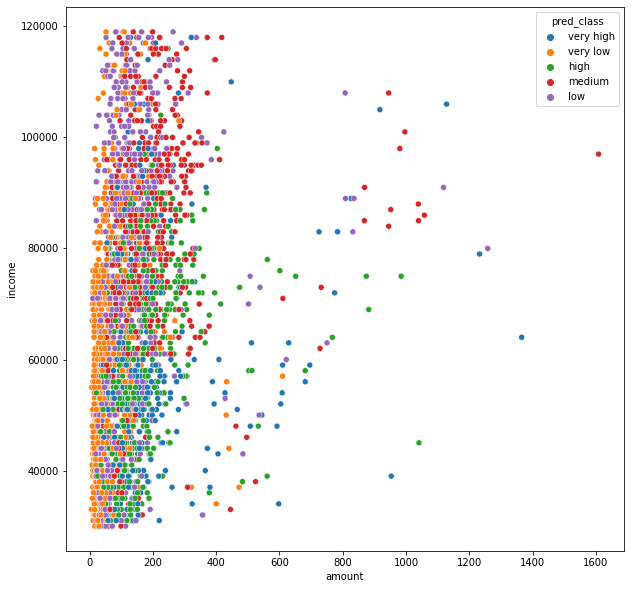

In [78]:
temp_df = pd.DataFrame()
temp_df['amount'] = X_test_amount
temp_df['income'] = X_test_income
temp_df['pred_class'] = y_pred_svc_balanced
fig, ax = plt.subplots()
sn.scatterplot(temp_df['amount'], temp_df['income'], hue=temp_df['pred_class']);

In [ ]:
Make with the help of the work of :https://github.com/zainfarrukh/starbucks-data-capstone/blob/main/Starbucks_Capstone_notebook.ipynb